In [78]:
!pip install umap-learn
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, adjusted_rand_score, rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss, accuracy_score, recall_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import umap
import hdbscan

# Flowers Dataset and VGG Features

In [80]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

In [81]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


In [82]:
#confirming original image size
dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
for i, (x,y) in enumerate(dataset):
    if i < 2:
      print(x.shape)
      print(y)
    else:
      break

torch.Size([3, 224, 224])
0
torch.Size([3, 224, 224])
0


In [83]:
#observe this is not a sparse matrix
print(np.count_nonzero(f_all)/4096) #this matches original sample size
print(f_all[99]) #values shown are not close to zero

3670.0
[-3.04757833 -0.73381233 -0.57437992 ... -3.70267153  2.33574653
  1.25055289]


In [7]:
#t-SNE
f_tsne = TSNE(n_components=2).fit_transform(f_all)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 't-SNE Plot')

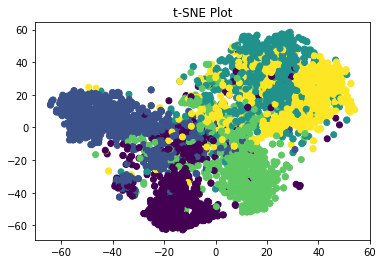

In [8]:
plt.scatter(*f_tsne.T, c=y_all)
plt.title("t-SNE Plot")

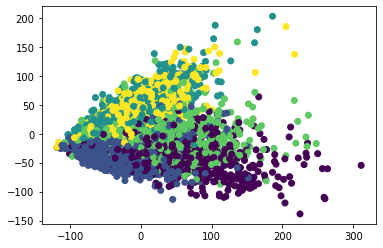

In [9]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

# MLP Classifier

In [84]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                X_ = X_.cuda()
                y_ = y_.cuda()
                # forward pass
                output = self.model(X_)
                loss = criterion(output, y_)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self

    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        X_test = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        
        self.model.eval()
        criterion = nn.NLLLoss()

        with torch.no_grad():
          y_pred = self.model(X_test)
          y_pred = np.argmax(y_pred.cpu().numpy(), axis=1)
        

        print(y_pred.shape, y_test.shape)
        print(y_pred[0], y_test[0])

        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        print(classification_report(y_test, y_pred))
        return adjusted_rand_score(y_test, y_pred)

# Autoencoder

In [85]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


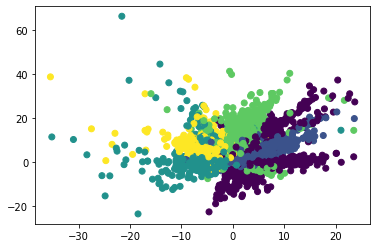

In [12]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

In [86]:
#Results for Grid Search

res = {}


In [87]:
#get the options for the reduced dataset
f_reduced = {}
f_reduced['None'] = f_all
f_reduced['SVD'] = TruncatedSVD(n_components=50).fit_transform(f_all)
f_reduced['UMAP'] = umap.UMAP(n_components=50).fit_transform(f_all)
f_reduced['Autoencoder'] = Autoencoder(50).fit_transform(f_all)

100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


In [88]:
clusteringOptions = {
    'K-Means': KMeans(n_clusters=5),
    'Agglomerative Clustering': AgglomerativeClustering(n_clusters=5),
    'HDBSCAN': None,
}

In [16]:
#get the results for the not HDBSCAN options
for key in clusteringOptions.keys():
    if key != 'HDBSCAN':
      for key2 in f_reduced.keys():
        if key == 'K-Means':
          clusteringModel = KMeans(n_clusters=5)
        else:
          clusteringModel = AgglomerativeClustering(n_clusters=5)
        newKey = key2 + ' and ' + key
        print(newKey)
        res[newKey] = clusteringModel.fit_predict(f_reduced[key2])

None and K-Means
SVD and K-Means
UMAP and K-Means
Autoencoder and K-Means
None and Agglomerative Clustering
SVD and Agglomerative Clustering
UMAP and Agglomerative Clustering
Autoencoder and Agglomerative Clustering


In [17]:
#get the results of the minimal grid search for HDBSCAN
min_cluster_sizes = [ 5, 50, 500 ]
min_samples = [ 5, 50, 500 ]

for key2 in f_reduced.keys():
  for clusterSize in min_cluster_sizes:
    for minSample in min_samples:
      newKey = key2 + ' and HDBSCAN with min cluster size ' + str(clusterSize) + ' and min samples ' + str(minSample)
      print(newKey)
      res[newKey] = hdbscan.HDBSCAN(min_cluster_size=clusterSize, min_samples=minSample).fit_predict(f_reduced[key2])



None and HDBSCAN with min cluster size 5 and min samples 5
None and HDBSCAN with min cluster size 5 and min samples 50
None and HDBSCAN with min cluster size 5 and min samples 500
None and HDBSCAN with min cluster size 50 and min samples 5
None and HDBSCAN with min cluster size 50 and min samples 50
None and HDBSCAN with min cluster size 50 and min samples 500
None and HDBSCAN with min cluster size 500 and min samples 5
None and HDBSCAN with min cluster size 500 and min samples 50
None and HDBSCAN with min cluster size 500 and min samples 500
SVD and HDBSCAN with min cluster size 5 and min samples 5
SVD and HDBSCAN with min cluster size 5 and min samples 50
SVD and HDBSCAN with min cluster size 5 and min samples 500
SVD and HDBSCAN with min cluster size 50 and min samples 5
SVD and HDBSCAN with min cluster size 50 and min samples 50
SVD and HDBSCAN with min cluster size 50 and min samples 500
SVD and HDBSCAN with min cluster size 500 and min samples 5
SVD and HDBSCAN with min cluster s

In [98]:
scores = {}

for key in res.keys():
  scores[key] = adjusted_rand_score( y_all, res[key])

In [99]:
print(scores)

{'test': 0.40178440308818203, 'test_Autoencoder': 0.22237820151421583, 'test_Autoencoder, agglomerative': 0.20551112096803711}


In [4]:
#need to know the top of this for Q25
for k, v in sorted( ((v,k) for k,v in scores.items()), reverse=True):
  print(k, v)

5 a
4 c
2 b


In [ ]:
#results: best combination was UMAP combined with K-Means

In [ ]:
#for question 25, choose UMAP dimensionality reduction with n_components = 50

In [58]:
#split data
f_train, f_test, y_train, y_test = train_test_split(f_all, y_all, random_state=42)

In [70]:
#initialize model
mdl = MLP(num_features=f_train.shape[1])
mdl.train(f_train, y_train)

100%|██████████| 100/100 [00:17<00:00,  5.87it/s]


MLP(
  (model): Sequential(
    (0): Linear(in_features=4096, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

(918,) (918,)
4 2.0
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       135
         1.0       0.92      0.94      0.93       240
         2.0       0.91      0.86      0.88       177
         3.0       0.93      0.93      0.93       191
         4.0       0.86      0.88      0.87       175

    accuracy                           0.91       918
   macro avg       0.91      0.91      0.91       918
weighted avg       0.91      0.91      0.91       918

Adjusted rand score is  0.7870796856946088


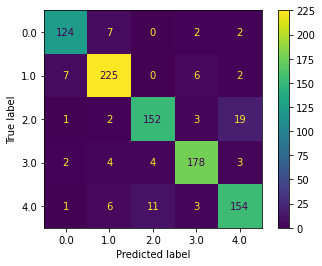

In [72]:
accuracy = mdl.eval(f_test, y_test)
print("Adjusted rand score is ", accuracy)

In [75]:
#evaluate for reduced dimension features
#in this case, using UMAP
umap_for_MLP = umap.UMAP(n_components=50)
f_train_umap = umap_for_MLP.fit_transform(f_train)
f_test_umap = umap_for_MLP.transform(f_test)

In [76]:
mdl = MLP(num_features=f_train_umap.shape[1])
mdl.train(f_train_umap, y_train)

100%|██████████| 100/100 [00:12<00:00,  7.72it/s]


MLP(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=1280, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1280, out_features=640, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=640, out_features=5, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

(918,) (918,)
2 2.0
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88       135
         1.0       0.80      0.97      0.88       240
         2.0       0.76      0.84      0.80       177
         3.0       0.92      0.80      0.85       191
         4.0       0.83      0.72      0.77       175

    accuracy                           0.84       918
   macro avg       0.86      0.83      0.84       918
weighted avg       0.85      0.84      0.84       918

Adjusted rand score is  0.6486398469927692


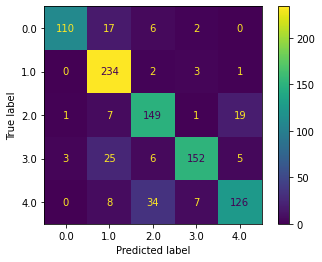

In [77]:
accuracy_umap_reduction = mdl.eval(f_test_umap, y_test)
print("Adjusted rand score is ", accuracy_umap_reduction)